In [94]:
import scipy.io
import scipy.misc
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

import random
import os

try:
    from os import scandir, walk
except ImportError:
    from scandir import scandir, walk

In [128]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

TO_TRAIN_PATH = '2500_TRAIN/'
GROUND_TRUTH_PATH = 'long_pants2500_TRUTH/'
VALIDATION_PATH = '997_Train/'

In [129]:
def conv2d_batch_relu(input, kernel_size, stride, num_filter, scope):
    with tf.variable_scope(scope):       
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
        conv_2d = tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

        batch = tf.layers.batch_normalization(conv_2d)
        relu = tf.nn.relu(batch)
        
        print(scope, ' output dim: ', relu.shape)
        return relu
    
def conv2d_transpose_batch_relu(input, kernel_size, stride, num_filter, output_dim, scope):
    with tf.variable_scope(scope):       
        stride_shape = [1, stride, stride, 1]
        shape = input.get_shape().as_list()
        filter_shape = [kernel_size, kernel_size, num_filter, shape[3]]
        output_shape = [shape[0], output_dim, output_dim, num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))        

        conv_2d = tf.nn.conv2d_transpose(input, W, output_shape, stride_shape)
        batch = tf.layers.batch_normalization(conv_2d)
        relu = tf.nn.relu(batch)
        
        print(scope, ' output dim: ', relu.shape)
        return relu

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    pool = tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')
    
    print('Max Pool Layer: ', pool.shape)
    return pool

def unsample(input, outputdim):
    unsample = tf.image.resize_nearest_neighbor(input, outputdim)
    
    print('Unsampling Layer: ', unsample.shape)
    return unsample

In [143]:
class SegmentationNN:
    def __init__(self):
        self.num_epoch = 10
        self.batch_size = 10
        self.input = tf.placeholder(tf.float32, [self.batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, 3])
        self.label = tf.placeholder(tf.float32, [self.batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, 1])
        self.output = self.build_model(self.input)
        print(self.output.shape)

        self.log_step = 50
        
        self.lr = 1e-4
        
        self.loss = self._loss(self.output, self.label)
        self.accuracy = self._accuracy(self.output, self.label)
        self.optimizer = self._optimizer()
        
    def load_data(self, TO_TRAIN_PATH, GROUD_TRUTH_PATH):
        to_train = []
        count=0
        label = []
        for file in scandir(TO_TRAIN_PATH):
            if file.name.endswith('jpg') or file.name.endswith('png') and file.is_file():
                print(file.name)
                image = scipy.misc.imread(file.path)
                image = scipy.misc.imresize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                to_train.append(image)
                
                image = scipy.misc.imread((GROUND_TRUTH_PATH + file.name).replace('jpg', 'png'))              
                image = scipy.misc.imresize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                image = np.reshape(image, (IMAGE_HEIGHT, IMAGE_WIDTH, 1))
                label.append(image)
                count = count + 1
        
        
        self.training_set = to_train
        self.label_set = label
        self.num_training = count
        return to_train, label

    def load_validation(self, VALIDATION_PATH):
        validation = []
        for file in scandir(VALIDATION_PATH):
            if file.name.endswith('jpg') or file.name.endswith('png') and file.is_file():
                image = scipy.misc.imread(file.path)
                image = scipy.misc.imresize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                validation.append(image)
        
        self.validation_set = validation
        return validation

        
    def build_model(self, input):
        conv1 = conv2d_batch_relu(input, 7, 2, 64, 'conv_1_1')
        conv2 = conv2d_batch_relu(conv1, 7, 1, 64, 'conv_1_2')
        max_pool_1 = max_pool(conv2, 3, 2)
        
        conv3 = conv2d_batch_relu(max_pool_1, 7, 2, 64, 'conv_1_3')
        conv4 = conv2d_batch_relu(conv3, 7, 1, 64, 'conv_1_4')
        max_pool_2 = max_pool(conv4, 3, 2)
        
        conv5 = conv2d_batch_relu(max_pool_2, 7, 2, 64, 'conv_1_5')
        conv6 = conv2d_batch_relu(conv5, 7, 1, 64, 'conv_1_6')
        max_pool_3 = max_pool(conv6, 3, 2)
        
        unsampled_1 = unsample(max_pool_3, [8,8])
        conv1 = conv2d_transpose_batch_relu(unsampled_1, 7, 1, 64, 8, 'conv_2_1')
        conv2 = conv2d_transpose_batch_relu(conv1, 7, 2, 64, 16, 'conv_2_2')
        
        unsampled_2 = unsample(conv2, [32,32])
        conv3 = conv2d_transpose_batch_relu(unsampled_2, 7, 1, 64, 32, 'conv_2_3')
        conv4 = conv2d_transpose_batch_relu(conv3, 7, 2, 64, 64, 'conv_2_4')
        
        unsampled_3 = unsample(conv5, [128,128])
        conv5 = conv2d_transpose_batch_relu(unsampled_3, 7, 1, 64, 128, 'conv_2_5')
        conv6 = conv2d_transpose_batch_relu(conv5, 7, 2, 1, 256, 'conv_2_6')
        
        return conv6
    
    def _loss(self, logits, labels):
        return tf.reduce_mean(tf.squared_difference(logits, labels))

    def _accuracy(self, logits, labels):
        return tf.reduce_mean(tf.divide(tf.abs(logits - labels), labels))

    def _optimizer(self):
        return tf.train.AdamOptimizer(learning_rate = self.lr).minimize(self.loss)
        
    def train(self, sess):
        iteration = 0
        losses = []
        accuracies = []
        for epoch in range(self.num_epoch):
            for it in range(self.num_training // self.batch_size):
                fetches = [self.optimizer, self.loss]
                
                _input = self.training_set[it*self.batch_size: (it+1)*self.batch_size]
                _label = self.label_set[it*self.batch_size: (it+1)*self.batch_size]
                
                feed_dict = {
                    self.input: _input,
                    self.label: _label
                }
        
                _, loss, accuracy = sess.run([self.optimizer, self.loss, self.accuracy], feed_dict = feed_dict)
            
                losses.append(loss)
                accuracies.append(accuracy)
            
                if iteration%self.log_step is 0:
                    print('iteration: {} loss: {}, accuracy: {}'.format(iteration, loss, accuracy))
                    
                iteration = iteration + 1
            
            feed_dict = {
                self.input: self.validation_set[0: self.batch_size]
            }
            generated_image = sess.run([self.output], feed_dict = feed_dict)
            
            images = np.concatenate(generated_image)
            images = images[:,:,:,0]
            images = np.reshape(images, (self.batch_size*IMAGE_HEIGHT, IMAGE_WIDTH))          
            save_path = 'output/epoch_{}.jpg'.format(epoch + 1)
            scipy.misc.imsave(save_path, images)

In [145]:
tf.reset_default_graph()
model1 = SegmentationNN()
trainning_set, label_set = model1.load_data(TO_TRAIN_PATH, GROUND_TRUTH_PATH)
validation_set = model1.load_validation(VALIDATION_PATH)

conv_1_1  output dim:  (10, 128, 128, 64)
conv_1_2  output dim:  (10, 128, 128, 64)
Max Pool Layer:  (10, 64, 64, 64)
conv_1_3  output dim:  (10, 32, 32, 64)
conv_1_4  output dim:  (10, 32, 32, 64)
Max Pool Layer:  (10, 16, 16, 64)
conv_1_5  output dim:  (10, 8, 8, 64)
conv_1_6  output dim:  (10, 8, 8, 64)
Max Pool Layer:  (10, 4, 4, 64)
Unsampling Layer:  (10, 8, 8, 64)
conv_2_1  output dim:  (10, 8, 8, 64)
conv_2_2  output dim:  (10, 16, 16, 64)
Unsampling Layer:  (10, 32, 32, 64)
conv_2_3  output dim:  (10, 32, 32, 64)
conv_2_4  output dim:  (10, 64, 64, 64)
Unsampling Layer:  (10, 128, 128, 64)
conv_2_5  output dim:  (10, 128, 128, 64)
conv_2_6  output dim:  (10, 256, 256, 1)
(10, 256, 256, 1)
2500_1683.jpg
2500_1697.jpg
2500_149.jpg
2500_607.jpg
2500_1867.jpg
2500_161.jpg
2500_175.jpg
2500_1873.jpg
2500_613.jpg
2500_820.jpg
2500_1126.jpg
2500_1640.jpg
2500_1898.jpg
2500_2349.jpg
2500_1654.jpg
2500_1132.jpg
2500_35.jpg
2500_834.jpg
2500_2413.jpg
2500_2375.jpg
2500_1668.jpg
2500_236

2240


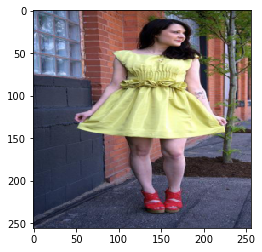

In [147]:
print(model1.num_training)

plt.imshow(trainning_set[10])
plt.show()

In [77]:
tf.reset_default_graph()

with tf.Session() as sess:
    model = SegmentationNN()
    sess.run(tf.global_variables_initializer())
    model.train(sess)

conv_1_1  output dim:  (10, 128, 128, 64)
conv_1_2  output dim:  (10, 128, 128, 64)
Max Pool Layer:  (10, 64, 64, 64)
conv_1_3  output dim:  (10, 32, 32, 64)
conv_1_4  output dim:  (10, 32, 32, 64)
Max Pool Layer:  (10, 16, 16, 64)
conv_1_5  output dim:  (10, 8, 8, 64)
conv_1_6  output dim:  (10, 8, 8, 64)
Max Pool Layer:  (10, 4, 4, 64)
Unsampling Layer:  (10, 8, 8, 64)
conv_2_1  output dim:  (10, 8, 8, 64)
conv_2_2  output dim:  (10, 16, 16, 64)
Unsampling Layer:  (10, 32, 32, 64)
conv_2_3  output dim:  (10, 32, 32, 64)
conv_2_4  output dim:  (10, 64, 64, 64)
Unsampling Layer:  (10, 128, 128, 64)
conv_2_5  output dim:  (10, 128, 128, 64)
conv_2_6  output dim:  (10, 256, 256, 1)
(10, 256, 256, 1)
Loss is  1.70891
